In this notebook i am resolving classic data science task - titanic survival probability. I used four different models, one custom class for data preprocessing, and one method to simplify the GridSearch process. Feel free to leave comments if you have any ideas for improvement.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import model_selection
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

path_to_train = "/kaggle/input/titanic/train.csv"
path_to_validat = "/kaggle/input/titanic/test.csv"

In [2]:
df = pd.read_csv(path_to_train)
valid_df = pd.read_csv(path_to_validat)

# Titanic dataset prewiew

Overview

The data has been split into two groups:

    data set (train.csv)
    validation set (test.csv)

The validation set should be used to build your machine learning models. For the data set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.


In [3]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


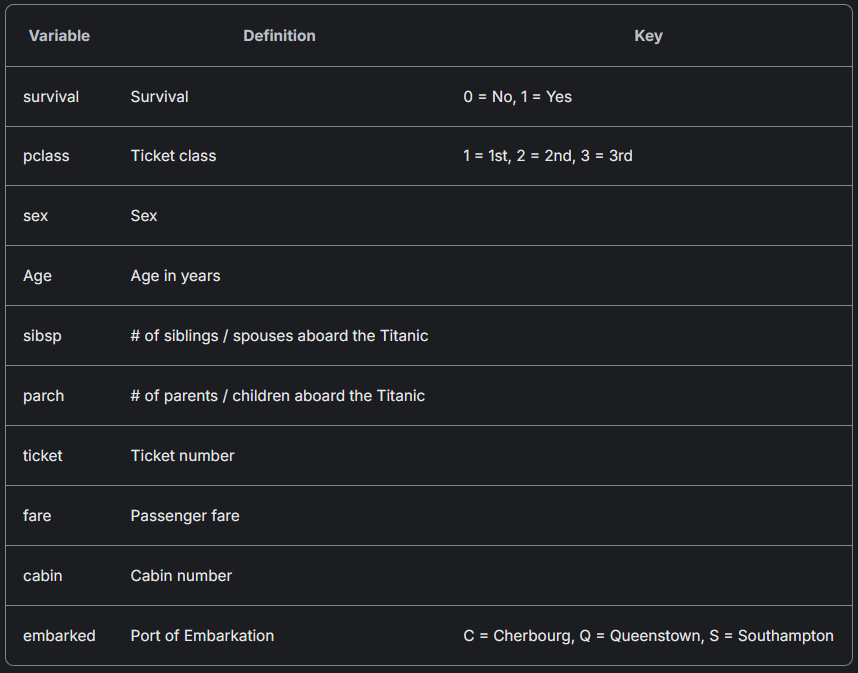



Variable Notes

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Some addition info

https://en.wikipedia.org/wiki/Titanic

In [4]:
df.sort_values(by='Fare').head(25)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0000,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S
674,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0000,B94,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S
732,733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0000,NaN,S


In [5]:
valid_df.sort_values(by='Fare').head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
266,1158,1,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0,0,112051,0.0000,NaN,S
372,1264,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0000,B52 B54 B56,S
21,913,3,"Olsen, Master. Artur Karl",male,9.0,0,1,C 17368,3.1708,NaN,S
133,1025,3,"Thomas, Mr. Charles P",male,NaN,1,0,2621,6.4375,NaN,C
116,1008,3,"Thomas, Mr. John",male,NaN,0,0,2681,6.4375,NaN,C


Three employees of American Line, as well as other staff members[Harland & Wolff : Titanic Guarantee Group](https://www.encyclopedia-titanica.org/titanic-guarantee-group/) were people who ended up on the Titanic for free, so they should be separated from other passengers for accurate ticket price predictions.

The "T" deck is an exception - [Blackwell](https://www.encyclopedia-titanica.org/titanic-victim/stephen-weart-blackwell.html) occupied cabin "T" on the Boat Deck

# Dataset preprocessing

# Transformer class

A multitasking class that handles all the work of preparing the DataFrame for the model.

In [6]:
class TitanicTransformer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
        return self

  def transform(self, X):
    """It converts data to numerical types, fills in missing values, and adds new columns."""
    #workers id that i found in "some addition info"
    self.workers_pid=[272, 598, 303, 634, 278, 414, 675, 264, 467, 733, 180, 807, 482, 823, 816, 873, 340, 1158]
    # A dictionary of possible Deck values for each Pclass.
    self.deck_choices = {
        1: ['A', 'B', 'C', 'D', 'E'],
        2: ['D', 'E', 'F'],
        3: ['E', 'F','G']
    }
    # feachure importance show that is_worker is useless, but i still leave it here to tell it
    X['is_worker'] = X['PassengerId'].isin(self.workers_pid).astype(int)

    # change of full columns into num type
    X['Embarked'] = X['Embarked'].map({'S': 0, 'C': 1, 'Q':2})
    X['Sex'] = X['Sex'].map({'male': 1, 'female': 0})
    # filling nans
    X['Age'].fillna(X['Age'].median(), inplace = True)
    X['Fare'].fillna(X['Fare'].median(), inplace = True)

    # Adding some more addition columns
    X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
    X['IsAlone'] = 1
    X['IsAlone'].loc[X['FamilySize'] > 1] = 0
    X['Title'] = X['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    X = X.drop('Name', axis=1)
    # Minimal same titles that lates sets to "Misc"
    stat_min = 10
    title_names = (X['Title'].value_counts() < stat_min)
    X['Title'] = X['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

    # changing some columns into more effective and encoding them
    X['FareBin'] = pd.qcut(X['Fare'], 4)
    X['AgeBin'] = pd.cut(X['Age'].astype(int), 5)
    label = LabelEncoder()
    X['Title_Code'] = label.fit_transform(X['Title'])
    X = X.drop('Title', axis=1)
    X['AgeBin_Code'] = label.fit_transform(X['AgeBin'])
    X = X.drop('AgeBin', axis=1)
    X['FareBin_Code'] = label.fit_transform(X['FareBin'])
    X = X.drop('FareBin', axis=1)

    #Ticket is just useless
    X = X.drop('Ticket', axis=1)

    # Adding Deck column that maded from Cabin and filling based on PClass
    X=self.deck_add(X)

    X['is_child'] = (X['Age'] < 14).astype(int)
    X['is_old'] = (X['Age'] > 50).astype(int)

    return X


  def fill_deck(self,row):
      deck_value = row['Deck']
      if isinstance(deck_value, list):
          if not deck_value:
              pclass = row['Pclass']
              new_deck = np.random.choice(self.deck_choices[pclass])  # random taking Deck from dictionary based on PClass
              return [new_deck]

      elif pd.isna(deck_value):
          pclass = row['Pclass']
          new_deck = np.random.choice(self.deck_choices[pclass])  # random taking Deck from dictionary based on PClass
          return [new_deck]
      return deck_value



  def deck_add(self,X):
      X['Deck'] = X['Cabin'].str.findall(r'[A-Za-z]+')
      # Some workers have special deck, so cut them out before random filling
      X_add= X[~(X['is_worker']==1)]
      X_add['Deck'] = X_add.apply(self.fill_deck, axis=1)

      # dont forget about workers
      filtered_rows = X[X['is_worker']==1]
      X = pd.concat([X_add, filtered_rows], ignore_index=True)

      # Since Deck contains lists, we have to use .explode and then collapse it back after processing.
      X = X.explode('Deck')
      X['Deck']=X['Deck'].map({'A': 1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'T':0})
      X = X.groupby(X.index).agg({
          'Deck': lambda x: list(x.dropna().unique()),
          **{col: 'first' for col in X.columns if col != 'Deck'}
      }).reset_index(drop=True)

      # i manualy found some exceptions in trainig df
      X['Deck'] = X['Deck'].apply(lambda x: [6.0] if x == [6.0, 7.0] else x)
      X['Deck'] = X['Deck'].apply(lambda x: [6.0] if x == [6.0, 5.0] else x)

      # For all else it will be 0 that equals "exception"
      X = X.explode('Deck')
      X['Deck'] = X['Deck'].fillna(0)

      #Adding new column, and droping non informative
      X['Cabin_not_Nan'] = X['Cabin'].fillna(0).apply(lambda x: 1 if x != 0 else 0)
      X = X.drop('Cabin', axis=1)
      return X



# Embarked fill

In [7]:
df[df['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


I found [Icard, Miss. Amelie](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html) - Embarked Southampton (S)

Also [Stone, Mrs. George Nelson (Martha Evelyn)](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html) is embarked Southampton (S)

In [8]:
df['Embarked'].fillna('S', inplace=True)
df['Embarked'].value_counts(dropna=False)

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

# Model

## Main settings

In this section, we will prepare the data for the model.

In [9]:
transformer = Pipeline([('transform_custom', TitanicTransformer())])
df = transformer.fit_transform(df)
valid_df = transformer.fit_transform(valid_df)

Using the trial-and-error method, we select the best features for the model. I leave some addition features that i dont use in comments.

In [10]:
X=df[['Deck','FamilySize','AgeBin_Code','FareBin_Code','Cabin_not_Nan','Sex','Pclass','Embarked','Title_Code']] #'SibSp','Parch','Age','Fare','is_worker',,'is_child','is_old''IsAlone',
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                test_size=0.2,
                                                random_state=42,
                                                stratify=y)

numeric_features = ['FamilySize', 'Sex']#'SibSp', 'Parch','Fare','Age','is_worker','IsAlone',
cat_features = ['FareBin_Code','AgeBin_Code','Cabin_not_Nan','Deck','Pclass','Embarked','Title_Code']#,,'is_child','is_old'

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(), cat_features),
    ]
)

## Custom method for fitting models

In [12]:
def custom_model_fit(models):


    name, model_info = next(iter(models.items()))
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_info['model'])
    ])

    grid_search = GridSearchCV(pipeline,
                                model_info['params'],
                                cv=10,
                                scoring='accuracy',
                                error_score="raise",
                                return_train_score=True)
    grid_search.fit(X_train, y_train)

    print("Best params:")
    print(grid_search.best_params_)

    best_estimator = grid_search.best_estimator_

    return best_estimator

## SGD

In [13]:
model_SGD_options = {
    'SGDClassifier': {
        'model': SGDClassifier(loss = 'log_loss', random_state=42,  max_iter = 2500, n_jobs = -1),
        'params': {'classifier__alpha': [0.005], 'classifier__class_weight': [None]}}
}

results = {}

In [14]:
SGDmodel = custom_model_fit(model_SGD_options)

Best params:
{'classifier__alpha': 0.005, 'classifier__class_weight': None}


### Score

In [15]:
SGDmodel.score(X_test, y_test)

0.8435754189944135

## LR

In [16]:
model_LR_options  = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter = 1000),
        'params': {'classifier__C': [0.2],
                   'classifier__class_weight': [None],
                   'classifier__solver': ['saga']}}
}

results = {}

In [17]:
LRmodel = custom_model_fit(model_LR_options)

Best params:
{'classifier__C': 0.2, 'classifier__class_weight': None, 'classifier__solver': 'saga'}


### Score

In [18]:
LRmodel.score(X_test, y_test)

0.8379888268156425

## KNN

In [19]:
model_KNN_options = {
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['minkowski', 'euclidean', 'manhattan'],
            'classifier__p': [1, 2],
        }
    }
}

results = {}

In [20]:
KNNmodel = custom_model_fit(model_KNN_options)

Best params:
{'classifier__metric': 'minkowski', 'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'uniform'}


### Score

In [21]:
KNNmodel.score(X_test, y_test)

0.8324022346368715

## RandomForest

In [22]:

model_RFC_options = {

    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'classifier__n_estimators': [500],
            'classifier__max_depth': [None, 10,  30],
            'classifier__bootstrap': [True],
            'classifier__class_weight': ['balanced', {0: 3, 1: 2}],
        }


}

}
results = {}

In [23]:
RFCmodel = custom_model_fit(model_RFC_options)

Best params:
{'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__n_estimators': 500}


### Score

In [24]:
RFCmodel.score(X_test, y_test)

0.8324022346368715

## Feature importance

In [25]:
from sklearn.inspection import permutation_importance
models_all=[SGDmodel,LRmodel,KNNmodel,RFCmodel]
models_name = ['SGDmodel','LRmodel','KNNmodel','RFCmodel']
result_importance=[]
for model_name in models_all:
  r = permutation_importance(model_name, X_test, y_test,
                           n_repeats=30,
                           random_state=0)
  result_importance.append(r.importances_mean)
PieX={}
for idx, model_importance in enumerate(result_importance):
    sorted_indices = model_importance.argsort()[::-1]
    PieX[models_name[idx]] = {
        X.columns[i]: model_importance[i] for i in sorted_indices
    }

PieXdf = pd.DataFrame(PieX)

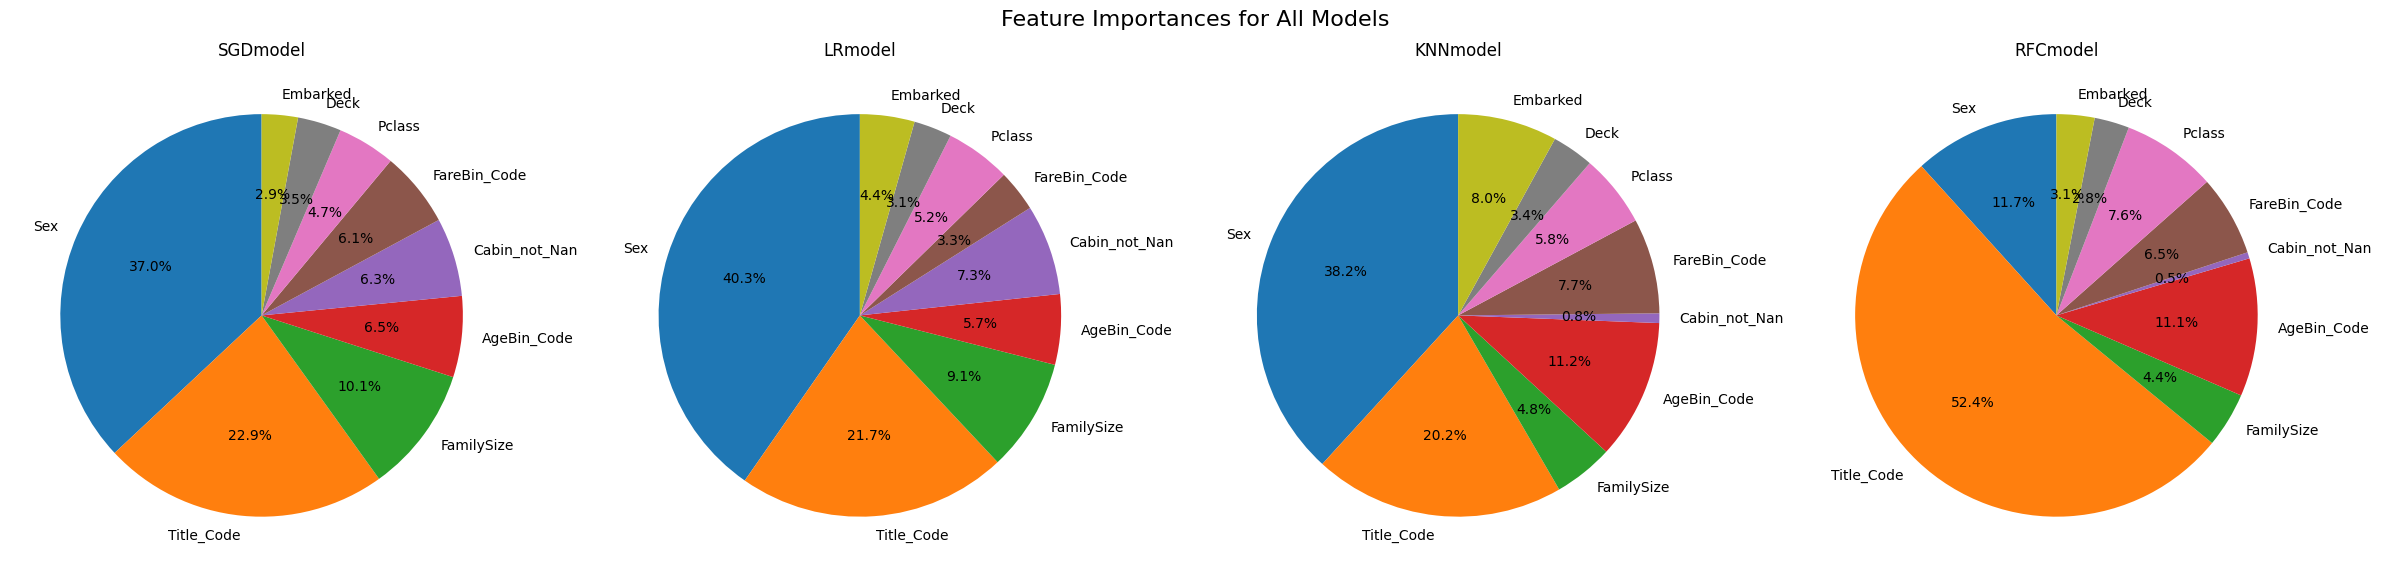

In [26]:
fig, axes = plt.subplots(1, len(PieX), figsize=(6 * len(PieX), 6))

if len(PieX) == 1:
    axes = [axes]

for idx, (model_name, feature_importances) in enumerate(PieX.items()):
    abs_importances = np.abs(PieXdf[model_name])
    axes[idx].pie(abs_importances,
                  labels=PieXdf.index,
                  autopct='%1.1f%%',
                  startangle=90)
    axes[idx].set_title(model_name)

plt.suptitle("Feature Importances for All Models", fontsize=16)
plt.tight_layout()
plt.show()

 ## Voting

In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

final_class = VotingClassifier(estimators=[('lr', LRmodel),('rfc', RFCmodel), ('sgd', SGDmodel),('knn', KNNmodel)], voting = 'hard')#
final_class = final_class.fit(X_train, y_train)

y_train_predict = final_class.predict(X_train)
y_test_predict = final_class.predict(X_test)
print(f'Train accuracy {(accuracy_score(y_train, y_train_predict),2)}, test accuracy{round(accuracy_score(y_test, y_test_predict),2)}')

Train accuracy (0.8553370786516854, 2), test accuracy0.84


In [28]:
#Stoping line for file naming
#--------------

In [29]:
valid_df['Survived'] = final_class.predict(valid_df)

In [30]:
final_valid_df=valid_df[['PassengerId','Survived']]

In [31]:
final_valid_df.to_csv('Name.csv', index=False)